In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install permetrics

## LOAD LIBRARIES

In [7]:
from transformers import BertModel, BertTokenizer, BertForPreTraining, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from textwrap import wrap
import matplotlib.pyplot as plt
import datetime
import copy

## GLOBAL VARIABLES

In [8]:
#https://www.researchgate.net/publication/345395208_BERTimbau_Pretrained_BERT_Models_for_Brazilian_Portuguese
class Config:
    NUM_GPU = 6
    NAME_MODEL = 'neuralmind/bert-base-portuguese-cased'
    MAX_LEN = 512
    RANDOM_SEED = 42
    NCLASSES = 5
    BATCH_SIZE = 16 #referencia BERTimbau 128
    LR = 0.0001 #referencia BERTimbau 1-e4
    EPOCHS = 10
    #------------------
    #NUM_MINOR_LABEL = Este se tiene que cambiar en el mismo codigo y probar
    PATH_DATASET = '../../dataset/df_classification_10porcent_utlcmovies_2024-05-14.csv'
    # Experimento LRxLayers
    PATH_RESULT_MODEL = './result/code_selfsupervised_BERTimabauBase-UTLCmovies-4lastlayersdefreeze-LR1e6/checkpoint-687531'
    #------------------------
config = Config()

np.random.seed(config.RANDOM_SEED)
torch.manual_seed(config.RANDOM_SEED)

## SELECT GPU

In [9]:
print("Número de GPUs disponibles:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Número de GPUs disponibles: 8
GPU 0: NVIDIA A100 80GB PCIe
GPU 1: NVIDIA A100 80GB PCIe
GPU 2: NVIDIA A100 80GB PCIe
GPU 3: NVIDIA A100 80GB PCIe
GPU 4: NVIDIA A100 80GB PCIe
GPU 5: NVIDIA A100 80GB PCIe
GPU 6: NVIDIA A100 80GB PCIe
GPU 7: NVIDIA A100 80GB PCIe


In [10]:
# Poner el GPU que deseo
torch.cuda.set_device(config.NUM_GPU)
# Para ver si esta utilizando GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#GPU usado actualmente
id_gpu = torch.cuda.current_device()
print(device,': GPU-',id_gpu)

cuda : GPU- 6


## LOAD WEIGHTS

In [11]:
#CARGAR EL MODELO
tokenizer = BertTokenizer.from_pretrained(config.NAME_MODEL)

modelBERT = BertModel.from_pretrained(config.NAME_MODEL,return_dict=False)# Modelo sin las capas de entrenamiento autosupervisionado

modelPreTraining = BertForPreTraining.from_pretrained(config.PATH_RESULT_MODEL)

#Pasar los pesos a un nuevo BERT
modelBERT.load_state_dict(modelPreTraining.bert.state_dict(), strict=False)#Para que no haya problemas al cargar distinto tipos de capas

modelBERT

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [12]:
# Pesos antes de entrenamiento
for name, param in modelBERT.named_parameters():
    print('------------------')
    print("=== Name: ",name)
    print('------------------')
    print(param)

------------------
=== Name:  embeddings.word_embeddings.weight
------------------
Parameter containing:
tensor([[ 0.0093, -0.0205,  0.0447,  ..., -0.0483, -0.0463,  0.0023],
        [ 0.0062, -0.0326,  0.0464,  ..., -0.0632, -0.0596, -0.0063],
        [-0.0138, -0.0493,  0.0093,  ..., -0.0138, -0.0428, -0.0009],
        ...,
        [ 0.0775, -0.0109,  0.0108,  ..., -0.0153, -0.0487,  0.0007],
        [ 0.0210, -0.0360,  0.0549,  ..., -0.0338, -0.0591,  0.0032],
        [-0.0074, -0.0173,  0.0024,  ..., -0.0348, -0.0257, -0.0028]],
       requires_grad=True)
------------------
=== Name:  embeddings.position_embeddings.weight
------------------
Parameter containing:
tensor([[-0.0378,  0.0038, -0.0299,  ...,  0.0320,  0.0005, -0.0145],
        [-0.0175, -0.0197,  0.0336,  ...,  0.0171,  0.0136, -0.0134],
        [ 0.0025, -0.0349,  0.0170,  ..., -0.0021,  0.0155, -0.0122],
        ...,
        [ 0.0081,  0.0739,  0.0219,  ..., -0.0117,  0.0033,  0.0668],
        [ 0.0169,  0.0470,  0.02

## FREEZE ALL LAYERS

In [13]:
# Congelar, por defecto todo esta congelado
for name, param in modelBERT.named_parameters():
    print(name)
    param.requires_grad = False
    print(param.requires_grad)

embeddings.word_embeddings.weight
False
embeddings.position_embeddings.weight
False
embeddings.token_type_embeddings.weight
False
embeddings.LayerNorm.weight
False
embeddings.LayerNorm.bias
False
encoder.layer.0.attention.self.query.weight
False
encoder.layer.0.attention.self.query.bias
False
encoder.layer.0.attention.self.key.weight
False
encoder.layer.0.attention.self.key.bias
False
encoder.layer.0.attention.self.value.weight
False
encoder.layer.0.attention.self.value.bias
False
encoder.layer.0.attention.output.dense.weight
False
encoder.layer.0.attention.output.dense.bias
False
encoder.layer.0.attention.output.LayerNorm.weight
False
encoder.layer.0.attention.output.LayerNorm.bias
False
encoder.layer.0.intermediate.dense.weight
False
encoder.layer.0.intermediate.dense.bias
False
encoder.layer.0.output.dense.weight
False
encoder.layer.0.output.dense.bias
False
encoder.layer.0.output.LayerNorm.weight
False
encoder.layer.0.output.LayerNorm.bias
False
encoder.layer.1.attention.self.query

## LOAD DATA B2W

In [14]:
# 10% data
df_data = pd.read_csv(config.PATH_DATASET, delimiter=',')#, usecols =['review_text','overall_rating'])# index_col=0,
df_data.head()

,review,label
0,E eu me atrevi a duvidar de Scorsese...,4
1,W. Smith iiincrivel!,4
2,ótimo achei excelente é o melhor,5
3,Cadê o bebê? olha ele aqui! -_-Cadê o bebê? ol...,5
4,O filme constrói bem a premissa de tensão em v...,3


In [15]:
df_data['label'].value_counts()

label
4    51998
5    46948
3    28632
2     9719
1     3436
Name: count, dtype: int64

In [16]:
#Cambiamos el label
df_data.loc[(df_data['label']==1), 'label'] = 0
df_data.loc[(df_data['label']==2), 'label'] = 1
df_data.loc[(df_data['label']==3), 'label'] = 2
df_data.loc[(df_data['label']==4), 'label'] = 3
df_data.loc[(df_data['label']==5), 'label'] = 4

df_data['label'].value_counts()

label
3    51998
4    46948
2    28632
1     9719
0     3436
Name: count, dtype: int64

## BALANCE TRAINING CLASSES

In [17]:
num_minor_label = 3436
# Obteniendo registros random del total de la misma etiqueta
label_0 = df_data.loc[df_data['label']==0,]
label_1 = df_data.loc[df_data['label']==1,].sample(num_minor_label, random_state=config.RANDOM_SEED)
label_2 = df_data.loc[df_data['label']==2,].sample(num_minor_label, random_state=config.RANDOM_SEED)
label_3 = df_data.loc[df_data['label']==3,].sample(num_minor_label, random_state=config.RANDOM_SEED)
label_4 = df_data.loc[df_data['label']==4,].sample(num_minor_label, random_state=config.RANDOM_SEED)
# Juntando todos los grupos y barajemos
df_data_new = (pd.concat([label_0, label_1, label_2, label_3, label_4])).sample(frac=1, random_state=config.RANDOM_SEED).reset_index(drop=True)
print(df_data_new.head())
print('------------------------------')
df_data_new['label'].value_counts()

                                              review  label
0  Muito boa a trama, muito bem pensado e dirigid...      3
1  bom filme baseada numa ótima história em quadr...      2
2                                  um mimo de filme.      2
3  Muiitooo  massa.... ameiii melhor filmeeee da ...      4
4  O próximo filme do universo de Invocação do Ma...      0
------------------------------


label
3    3436
2    3436
4    3436
0    3436
1    3436
Name: count, dtype: int64

## CREATE DATALOADER

In [18]:
class IMDBDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len#maximo cantidad de tokens

  def __len__(self):
      return len(self.reviews)
    
  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    #La forma en que ingresara a BERT
    encoding = tokenizer.encode_plus(
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        #pad_to_max_length = True,
        padding='max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    

    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      } 


#Cargando los datos
def textDataSet(df, tokenizer, max_len):
  dataset = IMDBDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return dataset

#CARGANDO LOS DATOS DE TRAIN Y VAL
dataset = textDataSet(df_data_new, tokenizer, config.MAX_LEN)

## CLASSIFICATION MODEL

In [19]:
# EL MODELO!
class BERTMultiClass(nn.Module):

  def __init__(self, n_classes):
    super(BERTMultiClass, self).__init__()
    self.bert = modelBERT
    self.drop = nn.Dropout(p=0.3)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

  def name(self):
    return "BERTMultiClass"

## CROSS VALIDATION

In [20]:
# Validación cruzada k fold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from permetrics.classification import ClassificationMetric

# Define k-fold cross-validation
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=config.RANDOM_SEED)

# Initialize lists to store metric for each fold
fold_was = []
fold_bas = []
fold_f1s = []
fold_cks = []

# TRAINING

In [21]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  val_predictions = []
  val_labels = []
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, predicted_labels = torch.max(outputs, dim=1)
      
      val_predictions.extend(predicted_labels.tolist())
      val_labels.extend(labels.tolist())
  return val_predictions, val_labels

Tiempo inicial: 06/20/2024, 02:19:14
Training Fold 1/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 1: 0.760895049472747
Balanced Accuracy for Fold 1: 0.4022950708522612
Weighted F1 for Fold 1: 0.39007636944178703
Cohen Kappa for Fold 1: 0.25280560086865633


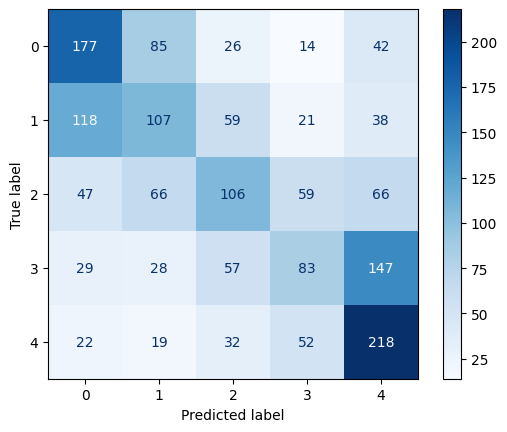

------------------
Training Fold 2/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 2: 0.7602062527697556
Balanced Accuracy for Fold 2: 0.4005695301376364
Weighted F1 for Fold 2: 0.38927133096118344
Cohen Kappa for Fold 2: 0.2506397685103038


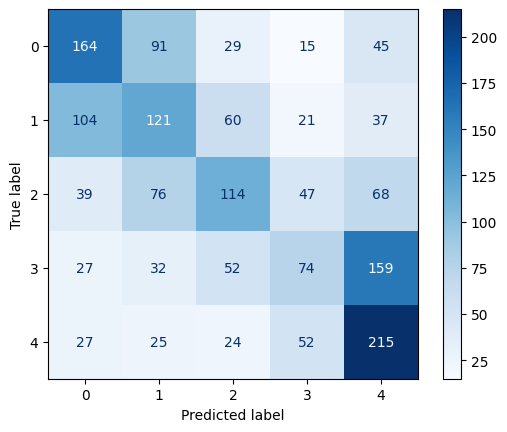

------------------
Training Fold 3/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 3: 0.7581005609305564
Balanced Accuracy for Fold 3: 0.3951556037697471
Weighted F1 for Fold 3: 0.37787018234023373
Cohen Kappa for Fold 3: 0.2440160869808281


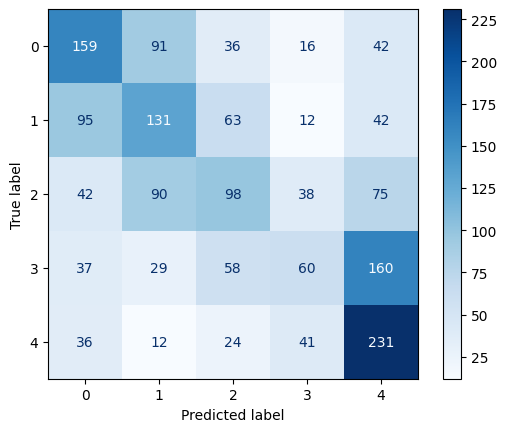

------------------
Training Fold 4/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 4: 0.7604237675180686
Balanced Accuracy for Fold 4: 0.40095599701674683
Weighted F1 for Fold 4: 0.385630541119063
Cohen Kappa for Fold 4: 0.251279792471809


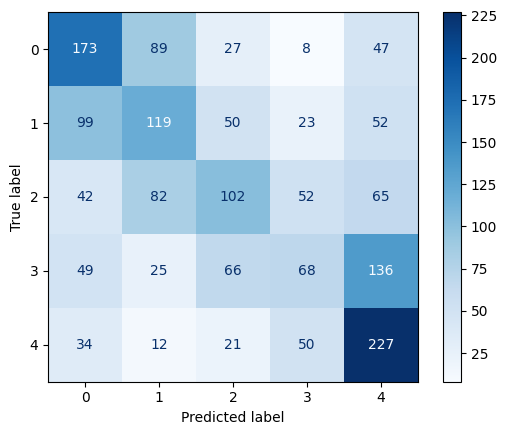

------------------
Training Fold 5/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 5: 0.7601723719678375
Balanced Accuracy for Fold 5: 0.40045765814631495
Weighted F1 for Fold 5: 0.38437082043506887
Cohen Kappa for Fold 5: 0.25056613906077885


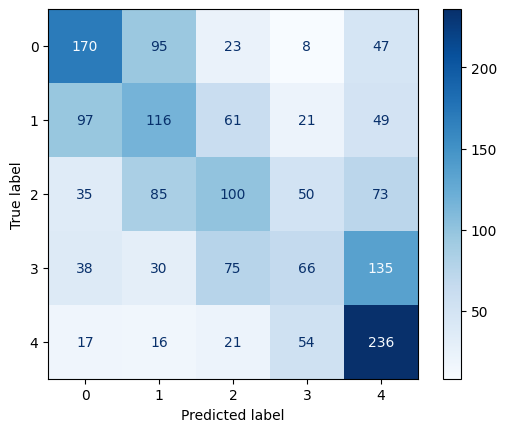

------------------
Training Fold 6/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 6: 0.7629790575987184
Balanced Accuracy for Fold 6: 0.4074716929961353
Weighted F1 for Fold 6: 0.38880714608629985
Cohen Kappa for Fold 6: 0.2593199931730814


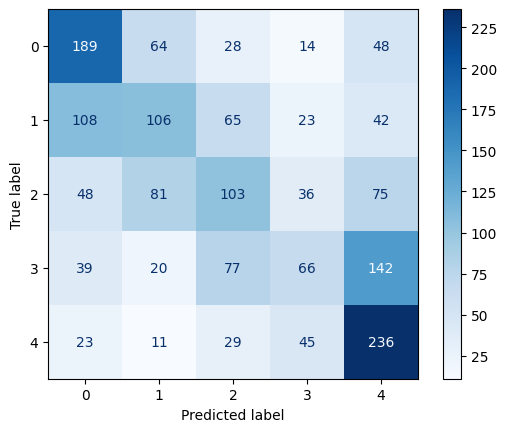

------------------
Training Fold 7/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 7: 0.76250370994781
Balanced Accuracy for Fold 7: 0.4061919452166249
Weighted F1 for Fold 7: 0.39022965977726204
Cohen Kappa for Fold 7: 0.25781296324218284


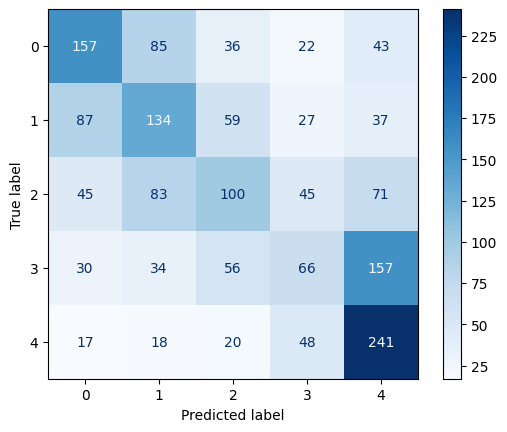

------------------
Training Fold 8/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 8: 0.7571397013881642
Balanced Accuracy for Fold 8: 0.3928249372838837
Weighted F1 for Fold 8: 0.3807852897042549
Cohen Kappa for Fold 8: 0.24107673033543198


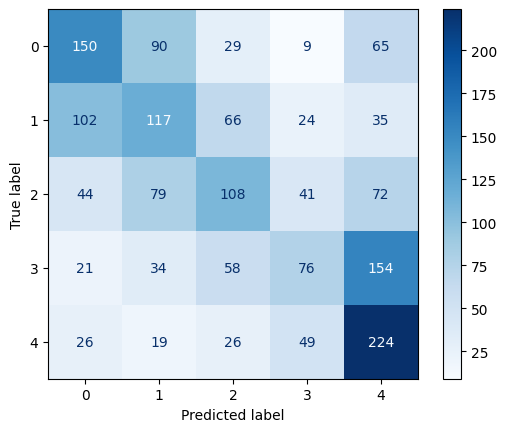

------------------
Training Fold 9/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 9: 0.7469182022575456
Balanced Accuracy for Fold 9: 0.36732829344362333
Weighted F1 for Fold 9: 0.3535836020059544
Cohen Kappa for Fold 9: 0.20912878921024514


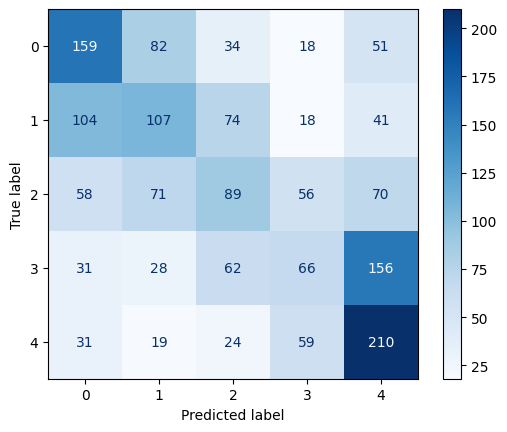

------------------
Training Fold 10/10
... Epoch 1 de 10
... Epoch 2 de 10
... Epoch 3 de 10
... Epoch 4 de 10
... Epoch 5 de 10
... Epoch 6 de 10
... Epoch 7 de 10
... Epoch 8 de 10
... Epoch 9 de 10
... Epoch 10 de 10
Weighted Accuracy for Fold 10: 0.7597054945174087
Balanced Accuracy for Fold 10: 0.3993423282934436
Weighted F1 for Fold 10: 0.3880131315543546
Cohen Kappa for Fold 10: 0.24912810014132503


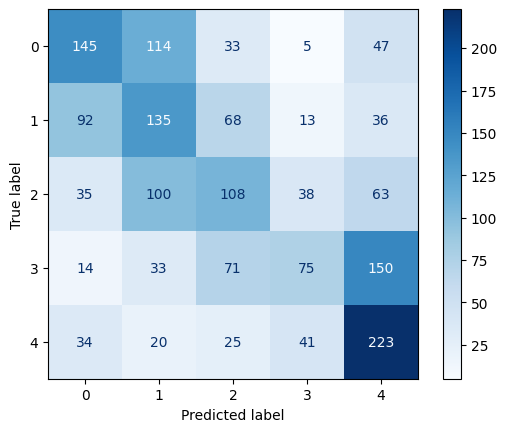

------------------
******************************************
Average Weighted Accuracy: 0.7589044168368613
Std Weighted Accuracy: 0.004326691696379995
Average Balanced Accuracy: 0.3972593057156417
Std Balanced Accuracy: 0.010810134446231526
Average Weighted F1: 0.3828638073425462
Std Weighted F1: 0.01051515507898323
Average Cohen Kappa: 0.24657739639946427
Std Cohen Kappa: 0.013519059260191693


In [22]:
### Reference: https://vtiya.medium.com/lets-code-k-fold-validation-on-bert-722f9438f932
#Tiempo
start = datetime.datetime.now()
print('Tiempo inicial:', start.strftime("%m/%d/%Y, %H:%M:%S"))

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(skf.split(df_data_new['review'], df_data_new['label'])):
    print(f"Training Fold {fold+1}/{k_folds}")
    
    # Split dataset into train and validation sets for the current fold
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers = 4)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers = 4)
    
    # MODEL
    # Instanciando el modelo
    classificationModel = BERTMultiClass(config.NCLASSES)
    classificationModel = classificationModel.to(device)
    
    # HIPERPARAMETRO
    optimizer = AdamW(classificationModel.parameters(), lr=config.LR)#, correct_bias=False)
    total_steps = len(train_loader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )
    loss_fn = nn.CrossEntropyLoss().to(device) # Funcion de perdida
        
    epoch = 0 # Inicializar
    
    # Entrenamiento!!!
    while epoch < config.EPOCHS:
      epoch += 1
      print('... Epoch {} de {}'.format(epoch, config.EPOCHS))
            
      train_model(
          classificationModel, train_loader, loss_fn, optimizer, device, scheduler, len(train_loader)
      )
    # Validacion
    val_predictions, val_labels = eval_model(
      classificationModel, val_loader, loss_fn, device, len(val_loader)
    )
    # Weighted Accuracy
    cm = ClassificationMetric(val_labels, val_predictions)
    fold_wa = cm.AS(average="weighted")
    fold_was.append(fold_wa)
    # Balanced Accuracy
    fold_ba = balanced_accuracy_score(val_labels, val_predictions)
    fold_bas.append(fold_ba)
    # Weighted F1 score
    fold_f1 = f1_score(val_labels, val_predictions, average='weighted')
    fold_f1s.append(fold_f1)
    # Cohen Kappa
    fold_ck = cohen_kappa_score(val_labels, val_predictions)
    fold_cks.append(fold_ck)
    print(f"Weighted Accuracy for Fold {fold+1}: {fold_wa}")
    print(f"Balanced Accuracy for Fold {fold+1}: {fold_ba}")
    print(f"Weighted F1 for Fold {fold+1}: {fold_f1}")
    print(f"Cohen Kappa for Fold {fold+1}: {fold_ck}")
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(val_labels, val_predictions)
    # Visualizar la matriz de confusión
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0,1,2,3,4])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()
    print('------------------')
print('******************************************')
# Calculate average and std across all folds
print(f"Average Weighted Accuracy: {np.mean(fold_was)}")
print(f"Std Weighted Accuracy: {np.std(fold_was)}")
print(f"Average Balanced Accuracy: {np.mean(fold_bas)}")
print(f"Std Balanced Accuracy: {np.std(fold_bas)}")
print(f"Average Weighted F1: {np.mean(fold_f1s)}")
print(f"Std Weighted F1: {np.std(fold_f1s)}")
print(f"Average Cohen Kappa: {np.mean(fold_cks)}")
print(f"Std Cohen Kappa: {np.std(fold_cks)}")

In [23]:
end = datetime.datetime.now()
print('Tiempo Final:', end.strftime("%m/%d/%Y, %H:%M:%S"))
print('Demoro en total:', end-start)

Tiempo Final: 06/20/2024, 08:40:19
Demoro en total: 6:21:05.204552


In [24]:
print(f"Average Weighted Accuracy: {np.mean(fold_was)}")
print(f"Std Weighted Accuracy: {np.std(fold_was)}")
print(f"Average Balanced Accuracy: {np.mean(fold_bas)}")
print(f"Std Balanced Accuracy: {np.std(fold_bas)}")
print(f"Average Weighted F1: {np.mean(fold_f1s)}")
print(f"Std Weighted F1: {np.std(fold_f1s)}")
print(f"Average Cohen Kappa: {np.mean(fold_cks)}")
print(f"Std Cohen Kappa: {np.std(fold_cks)}")

Average Weighted Accuracy: 0.7589044168368613
Std Weighted Accuracy: 0.004326691696379995
Average Balanced Accuracy: 0.3972593057156417
Std Balanced Accuracy: 0.010810134446231526
Average Weighted F1: 0.3828638073425462
Std Weighted F1: 0.01051515507898323
Average Cohen Kappa: 0.24657739639946427
Std Cohen Kappa: 0.013519059260191693


In [25]:
fold_bas

[0.4022950708522612,
 0.4005695301376364,
 0.3951556037697471,
 0.40095599701674683,
 0.40045765814631495,
 0.4074716929961353,
 0.4061919452166249,
 0.3928249372838837,
 0.36732829344362333,
 0.3993423282934436]

In [26]:
fold_f1s

[0.39007636944178703,
 0.38927133096118344,
 0.37787018234023373,
 0.385630541119063,
 0.38437082043506887,
 0.38880714608629985,
 0.39022965977726204,
 0.3807852897042549,
 0.3535836020059544,
 0.3880131315543546]

In [27]:
fold_cks

[0.25280560086865633,
 0.2506397685103038,
 0.2440160869808281,
 0.251279792471809,
 0.25056613906077885,
 0.2593199931730814,
 0.25781296324218284,
 0.24107673033543198,
 0.20912878921024514,
 0.24912810014132503]